# Purpose of the Notebook

What is meant by Feature Selection is that we are trying to select the (combination of) features which have the most positive impact on the performance of the model. 

# Feature Selection

In order to make a selection, the feature importance is determined using the coefficients of the model. Coefficients in multiple linear models represent the relationship between the given feature and the target, assuming that all the other features remain constant (conditional dependence). 

In [1]:
# imports
import pandas as pd
import X3_Forecasting as forecast
import orga_functions as org
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

Since the coefficients used by the model to calculate the prediction depend on the scale in which the values of the respective feature vary, the **normalized dataset** is used to determine the feature importance. In this dataset, the values of all features vary on the same scale.

In [2]:
# read in the data
df = pd.read_csv(org.path("03_AirQuality_normalized.csv"), sep=';')

The model must be trained to be able to extract the coefficients from it. Therefore, a time shift has to be applied first to get the target column 'ah_target':

In [3]:
# shift abs humidty values by 6 hrs
target = 'ah_target'
df[target] = df.ah.shift(periods=-6)

In [4]:
# check for difference
df.head(8)

,date,co_gt,pt08_s1_co,nmhc_gt,c6h6_gt,pt08_s2_nmhc,nox_gt,pt08_s3_nox,no2_gt,pt08_s4_no2,pt08_s5_o3,t,rh,ah,ah_target
0,2004-03-10 18:00:00,0.454545,0.688224,0.225197,0.409722,0.311975,0.263242,0.649558,0.509174,0.616822,0.557692,0.308585,0.499371,0.7578,0.7603
1,2004-03-10 19:00:00,0.345455,0.622587,0.165354,0.322917,0.216387,0.162119,0.753982,0.412844,0.533956,0.395055,0.301624,0.484277,0.7255,0.7702
2,2004-03-10 20:00:00,0.381818,0.728764,0.127559,0.309028,0.199580,0.207063,0.723894,0.513761,0.531464,0.451099,0.269142,0.563522,0.7502,0.7648
3,2004-03-10 21:00:00,0.381818,0.703668,0.114961,0.315972,0.209034,0.272873,0.681416,0.550459,0.549533,0.521978,0.248260,0.638994,0.7867,0.7517
4,2004-03-10 22:00:00,0.272727,0.603282,0.069291,0.222222,0.091387,0.207063,0.781416,0.522936,0.490966,0.470879,0.252900,0.633962,0.7888,0.7465
5,2004-03-10 23:00:00,0.200000,0.530888,0.048819,0.159722,0.001050,0.139647,0.898230,0.431193,0.430530,0.382418,0.252900,0.628931,0.7848,0.7366
6,2004-03-11 00:00:00,0.200000,0.519305,0.037795,0.121528,0.214894,0.096308,0.466162,0.344037,0.393146,0.263736,0.255220,0.598742,0.7603,0.7353
7,2004-03-11 01:00:00,0.163636,0.472008,0.037795,0.111111,0.214894,0.096308,0.466162,0.339450,0.393146,0.262088,0.241299,0.638994,0.7702,0.7417


> As you can see, in each case a target value corresponds to the value that was actually measured 6 hours later.

Drop rows where target is unknown (last 6 rows with NaN ah_target):

In [5]:
# drop unknown target-rows
df.dropna(subset=[target], inplace=True)

Split the Dataset into a set for training the model and one for testing its performance:

In [6]:
# Train-/ test-split
training, test = train_test_split(df, test_size=1000, shuffle=False, random_state=1999)

Definition of the features that are to be used to train the model. Be careful, because this also restricts the features for which the coefficient is obtained.
In this case, 'date' and 'ah_target' is being omitted because it's not necessary.

In [7]:
features = ['co_gt', 'pt08_s1_co',"c6h6_gt","pt08_s2_nmhc", "nox_gt", "pt08_s3_nox","no2_gt", "pt08_s4_no2",
            "pt08_s5_o3", "t", "ah"]

Split the training set and the test set into input (Xi) and target (y):

In [8]:
# Split into input and target
X_train = training[features]
y_train = training[target]
x_test = test[features]
y_test = test[target]

Defining the model and training it:

In [9]:
# define the model
model = LinearRegression()

# fit the model
model.fit(X_train, y_train)

LinearRegression()

Show the Coefficients for each feature:

In [10]:
# get importance
importance = model.coef_

# summarize feature importance
coefs = pd.DataFrame(
    [importance]
)
coefs = coefs.T
coefs.columns= ['Coefficient']
coefs["feature_names"] = pd.DataFrame(features)
coefs.set_index("feature_names", inplace=True)

coefs

,Coefficient
feature_names,
co_gt,0.028777
pt08_s1_co,-0.001742
c6h6_gt,0.037681
pt08_s2_nmhc,0.019976
nox_gt,-0.019546
pt08_s3_nox,-0.027832
no2_gt,-0.000379
pt08_s4_no2,-0.177317
pt08_s5_o3,0.032013


Plotting of the table to determine important features more easily:

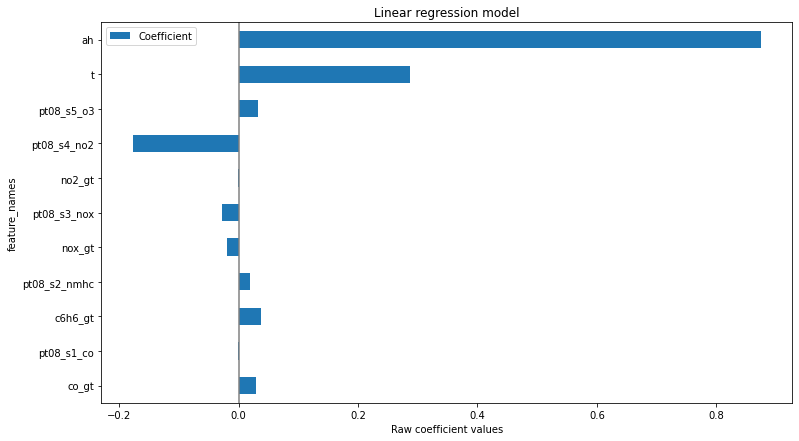

In [11]:
# plot feature importance
coefs.plot.barh(figsize=(16, 7))
plt.axvline(x=0, color=".5")
plt.title("Linear regression model")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

> The Features 'ah', 't' and 'pt08_s4_no2' have the highest feature importance

# Testing the performance

Definition of the features that are to be used to train the model. This time, the model is being trained with the most important features to determine their impact on performance. 

The method to find the best performing combination of features works by first finding out the performance when all features are being used to train the model. Then one feature at a time is removed and measured again. The order in which the features are removed is determined by sorting by the ascending absolute value of the coefficient. So the feature with the smallest absolute coefficient is removed first.

In [12]:
# feature combination - performance (mean absolute error)

# features = ["co_gt", "c6h6_gt","pt08_s2_nmhc", "nox_gt", "pt08_s3_nox", "pt08_s4_no2","pt08_s5_o3", "t", "ah"] - 0.06295
# features = ["co_gt", "c6h6_gt", "nox_gt", "pt08_s3_nox", "pt08_s4_no2","pt08_s5_o3", "t", "ah"] - 0.06281
# features = ["co_gt", "c6h6_gt", "pt08_s3_nox", "pt08_s4_no2","pt08_s5_o3", "t", "ah"] - 0.06214
# features = ["co_gt", "c6h6_gt", "pt08_s4_no2","pt08_s5_o3", "t", "ah"] - 0.06153
# features = ["c6h6_gt", "pt08_s4_no2","pt08_s5_o3", "t", "ah"] - 0.06164
# features = ["c6h6_gt", "pt08_s4_no2", "t", "ah"] - 0.06082
# features = ["pt08_s4_no2", "t", "ah"] - 0.05871
features = ["t", "ah"] # - 0.05639    --- Best performance here ---
# features = ["ah"] - 0.07291

# --- 'ah' normalized: 

# features = ["t", "ah"] - 0.02775 !!    (see #TODO 1 at the end)

In [13]:
# Split into input and target
X_train = training[features]
y_train = training[target]
x_test = test[features]
y_test = test[target]

# fit the model
model.fit(X_train, y_train)

# make prediction
pred_linr_y = model.predict(x_test)

# calculate mean absolute error between prediction an target
mean_absolute_error(y_test, pred_linr_y)

0.0563969743878939

# ToDo's - Opportunities for improvement

Below you will find some concepts that could improve the pipeline, but which have not yet been implemented due to time constraints or other reasons.

In [14]:
#TODO 1: The column 'ah' can be normalized too in step 4 (Feature Scaling). 
#        This will improve the performance quite a bit, as you can tell from the list 
#        of performance values per combination. The last performance value belongs to the best combination, 
#        but with previously normalized 'ah' column. As you can see, the performance is almost doubled (!). 
#        The reason why this has not yet been implemented is that it would have an impact on other parts of the pipeline, 
#        which could not be addressed due to time constraints. For example, a prediction made by the model 
#        would first have to be calculated back to the original scaling before the value could be interpreted.